In [97]:
%reload_ext autoreload
%autoreload 2

import os
import warnings

import pandas as pd

from hydra import compose, initialize, core
from omegaconf import OmegaConf

from src.long.var import VARTrainer
from src.long.snaive import SNaiveTrainer
from src.long.stl import STLTrainer
from src.custom_utils import CVHelper, S3Helper

## Hydra

In [67]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(
    version_base="1.2", config_path="../src/config", job_name="long_term_forecast"
)
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

## Configurations

The configurations for long-term (3 years or 36 months) forecasting:

In [61]:
config["long"]

{'output_key': 'data/processed/long',
 'start_date': '2013-01-31',
 'end_date': '2023-06-30',
 'forecast_horizon': 36,
 'freq': 'M',
 'm': 12,
 'window_length': 42,
 'step_length': 1,
 'metric': 'rmse',
 'pred_interval': 0.9,
 'model_key': 'models/long'}

## Train & Test Data

In [62]:
s3_helper = S3Helper()

y_train = s3_helper.read_parquet(
    obj_key=os.path.join(config["long"]["output_key"], "train.parquet")
)
y_test = s3_helper.read_parquet(
    obj_key=os.path.join(config["long"]["output_key"], "test.parquet")
)

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (90, 5)
y_test shape: (36, 5)


## VAR

The first baseline we try for long-term is the VAR model. The model pipeline simply includes

1. A log transformation
2. Tunable steps to detrend or deseasonalize the time series
3. Vector Auto-Regressive model, tuning the trend parameter e.g., constant, constant + trend, constant, etc.

The window size and step size for time series cross-validation in the configurations above are set to ensure a certain number of fits:

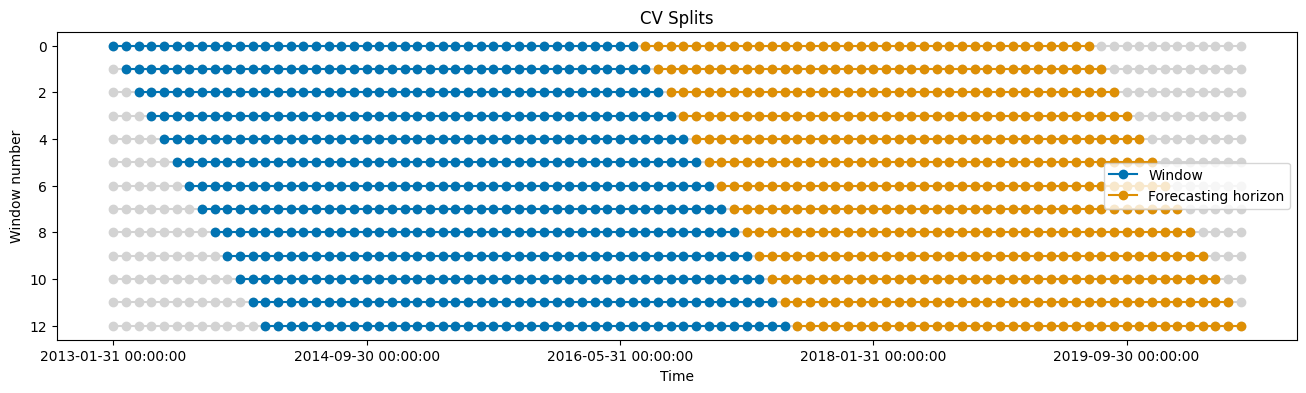

In [5]:
CVHelper.plot_cv_windows(
    w=config["long"]["window_length"],
    s=config["long"]["step_length"],
    h=config["long"]["forecast_horizon"],
    start_date=y_train["service_date"].min(),
    end_date=y_train["service_date"].max(),
    freq=config["long"]["freq"],
)

### Cross-Validation

### Counterfactual Data

We start with counterfactual data:

In [85]:
var_trainer_counterfactual = VARTrainer(
    horizon="long",
    config_path="../src/config",
    config_name="counterfactual_var_trainer",
    logger_name="counterfactual_var_trainer",
    s3_helper=s3_helper,
    data_type="counterfactual",
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    var_trainer_counterfactual.cross_validate(verbose=2, n_jobs=-1, refit=True)

2023-11-07 00:05:46,005 INFO counterfactual_var_trainer: Ingesting data...
2023-11-07 00:05:46,402 INFO counterfactual_var_trainer: Creating cross-validation splitter...
2023-11-07 00:05:46,404 INFO counterfactual_var_trainer: Creating model...
Fitting 14 folds for each of 16 candidates, totalling 224 fits
2023-11-07 00:05:56,473 INFO counterfactual_var_trainer: Best params: {'deseasonalize__passthrough': False, 'detrend__passthrough': False, 'var__trend': 'ct'}
2023-11-07 00:05:56,475 INFO counterfactual_var_trainer: Best score: 47461.87364166952


CV results:

In [7]:
var_trainer_counterfactual.grid_search.cv_results_.sort_values(
    "mean_test_MeanSquaredError"
)

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
14,47461.873642,0.162733,0.041515,"{'deseasonalize__passthrough': False, 'detrend...",1.0
10,49184.448573,0.143042,0.041020,"{'deseasonalize__passthrough': False, 'detrend...",2.0
12,52816.374491,0.151128,0.052381,"{'deseasonalize__passthrough': False, 'detrend...",3.0
13,53264.884256,0.155970,0.047306,"{'deseasonalize__passthrough': False, 'detrend...",4.0
9,57753.899319,0.142494,0.041047,"{'deseasonalize__passthrough': False, 'detrend...",5.0
8,58701.194807,0.137589,0.045757,"{'deseasonalize__passthrough': False, 'detrend...",6.0
1,66526.800545,0.158505,0.053714,"{'deseasonalize__passthrough': True, 'detrend_...",7.0
4,68032.284273,0.224488,0.067929,"{'deseasonalize__passthrough': True, 'detrend_...",8.0
6,75601.565475,0.236321,0.058930,"{'deseasonalize__passthrough': True, 'detrend_...",9.0
15,77256.074832,0.162645,0.041881,"{'deseasonalize__passthrough': False, 'detrend...",10.0


Best parameters:

In [8]:
pd.DataFrame(
    var_trainer_counterfactual.grid_search.best_params_, index=["Best Parameters"]
)

,deseasonalize__passthrough,detrend__passthrough,var__trend
Best Parameters,False,False,ct


#### Diagnostics

In [9]:
diagnostics_cv_var_counterfactual = var_trainer_counterfactual.diagnostics(
    full_model=False
)
diagnostics_cv_var_counterfactual["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


In [10]:
diagnostics_cv_var_counterfactual["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


As can be seen, the model assumptions for residuals--- normality and independence--- are both well satisfied.

#### Refit and Forecast

In [11]:
forecast_results_var_counterfactual = var_trainer_counterfactual.refit_and_forecast(
    level=config["long"]["pred_interval"]
)

2023-11-06 16:00:44,604 INFO counterfactual_var_trainer: Refitting model on entire data...


2023-11-06 16:00:44,733 INFO counterfactual_var_trainer: Making out-of-sample forecasts...


Diagnostics:

In [12]:
diagnostics_refit_var_counterfactual = var_trainer_counterfactual.diagnostics(
    full_model=True
)
diagnostics_refit_var_counterfactual["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


In [13]:
diagnostics_refit_var_counterfactual["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


Plot out-of-sample forecasts:

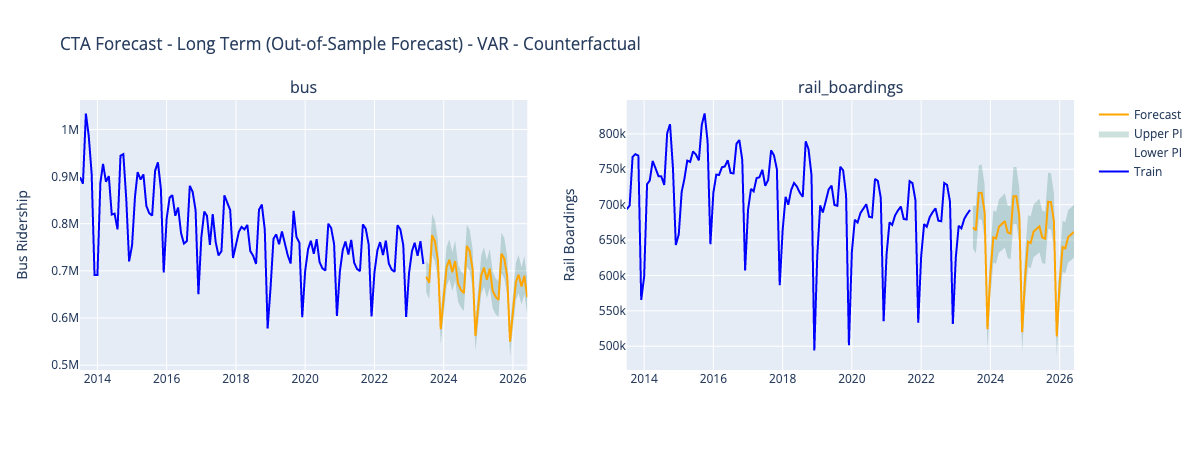

In [19]:
var_trainer_counterfactual.plot_forecast(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=365.25 * 10),
    pi=forecast_results_var_counterfactual["pi"],
    y_train=forecast_results_var_counterfactual["y_train"],
    y_pred=forecast_results_var_counterfactual["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Long Term (Out-of-Sample Forecast) - VAR - Counterfactual",
)

### Original Data

In [20]:
var_trainer_original = VARTrainer(
    horizon="long",
    config_path="../src/config",
    config_name="original_var_trainer",
    logger_name="original_var_trainer",
    s3_helper=s3_helper,
    data_type="original",
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    var_trainer_original.cross_validate(verbose=2, n_jobs=-1, refit=True)

2023-11-06 16:02:00,002 INFO original_var_trainer: Ingesting data...
2023-11-06 16:02:00,496 INFO original_var_trainer: Creating cross-validation splitter...
2023-11-06 16:02:00,498 INFO original_var_trainer: Creating model...
Fitting 14 folds for each of 16 candidates, totalling 224 fits
2023-11-06 16:02:09,275 INFO original_var_trainer: Best params: {'deseasonalize__passthrough': False, 'detrend__passthrough': False, 'var__trend': 'ct'}
2023-11-06 16:02:09,276 INFO original_var_trainer: Best score: 78134.4796185659


CV results:

In [21]:
var_trainer_original.grid_search.cv_results_.sort_values("mean_test_MeanSquaredError")

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
14,78134.479619,0.220509,0.065056,"{'deseasonalize__passthrough': False, 'detrend...",1.0
10,79669.950748,0.161412,0.056877,"{'deseasonalize__passthrough': False, 'detrend...",2.0
12,83075.896424,0.255285,0.058098,"{'deseasonalize__passthrough': False, 'detrend...",3.0
13,83255.657556,0.223693,0.067906,"{'deseasonalize__passthrough': False, 'detrend...",4.0
9,87327.967119,0.159137,0.057512,"{'deseasonalize__passthrough': False, 'detrend...",5.0
8,88028.845094,0.166027,0.048492,"{'deseasonalize__passthrough': False, 'detrend...",6.0
15,88096.119792,0.247987,0.066641,"{'deseasonalize__passthrough': False, 'detrend...",7.0
11,91202.612317,0.158262,0.056283,"{'deseasonalize__passthrough': False, 'detrend...",8.0
1,93351.270848,0.107809,0.029721,"{'deseasonalize__passthrough': True, 'detrend_...",9.0
4,93551.337733,0.177007,0.048047,"{'deseasonalize__passthrough': True, 'detrend_...",10.0


Best parameters:

In [22]:
pd.DataFrame(var_trainer_original.grid_search.best_params_, index=["Best Parameters"])

,deseasonalize__passthrough,detrend__passthrough,var__trend
Best Parameters,False,False,ct


#### Diagnostics

In [23]:
diagnostics_cv_var_original = var_trainer_original.diagnostics(full_model=False)
diagnostics_cv_var_original["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


In [24]:
diagnostics_cv_var_original["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


#### Refit and Forecast

In [25]:
forecast_results_var_original = var_trainer_original.refit_and_forecast(
    level=config["long"]["pred_interval"]
)

2023-11-06 16:02:10,390 INFO original_var_trainer: Refitting model on entire data...
2023-11-06 16:02:10,489 INFO original_var_trainer: Making out-of-sample forecasts...


In [26]:
diagnostics_refit_var_original = var_trainer_original.diagnostics(full_model=True)
diagnostics_refit_var_original["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


In [27]:
diagnostics_refit_var_original["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


Plot out-of-sample forecats:

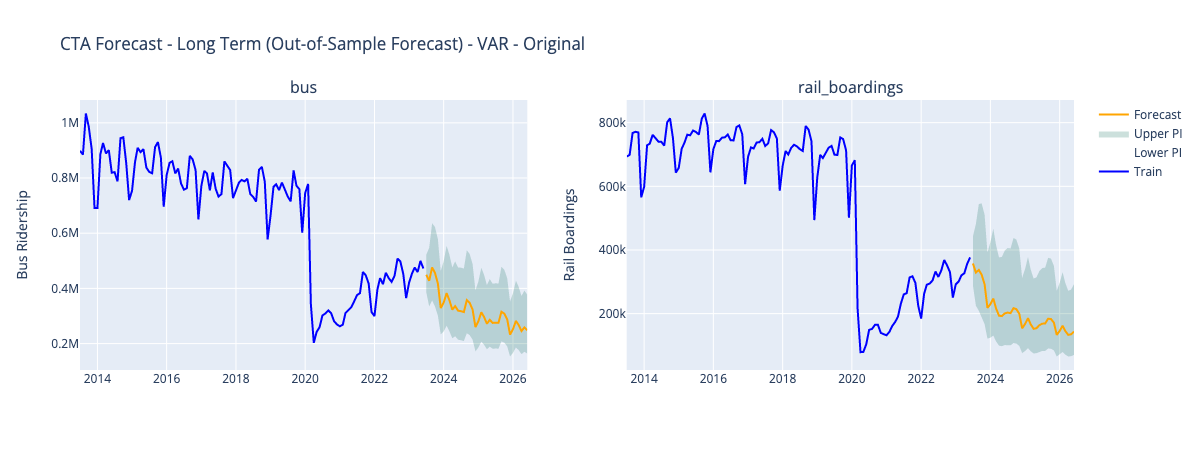

In [28]:
var_trainer_original.plot_forecast(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=365.25 * 10),
    pi=forecast_results_var_original["pi"],
    y_train=forecast_results_var_original["y_train"],
    y_pred=forecast_results_var_original["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Long Term (Out-of-Sample Forecast) - VAR - Original",
)

### VAR Comparison Plot (Counterfactual vs Original)

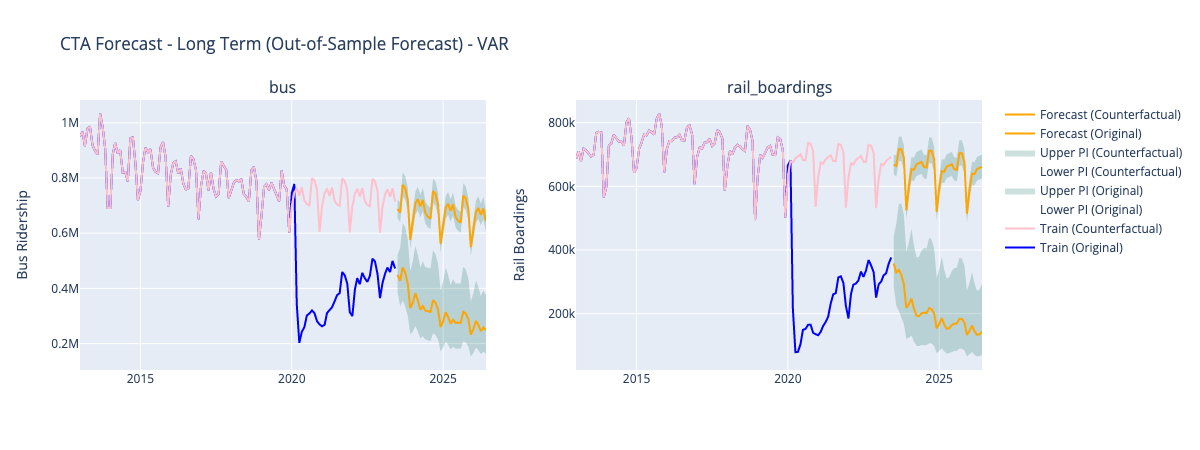

In [31]:
VARTrainer.plot_forecast_comparison(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=365.25 * 10),
    pi_original=forecast_results_var_original["pi"],
    y_train_original=forecast_results_var_original["y_train"],
    y_pred_original=forecast_results_var_original["y_pred"],
    pi_counterfactual=forecast_results_var_counterfactual["pi"],
    y_train_counterfactual=forecast_results_var_counterfactual["y_train"],
    y_pred_counterfactual=forecast_results_var_counterfactual["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Long Term (Out-of-Sample Forecast) - VAR",
)

### Model Persistence

In [36]:
for trainer, data_type in zip(
    [var_trainer_counterfactual, var_trainer_original], ["counterfactual", "original"]
):
    trainer.upload_trainer(
        obj_key=os.path.join(
            config["long"]["model_key"], f"{data_type}_var_trainer.joblib"
        )
    )

2023-11-06 16:04:43,344 INFO counterfactual_var_trainer: Uploaded trainer object to models/long/counterfactual_var_trainer.joblib
2023-11-06 16:04:44,421 INFO original_var_trainer: Uploaded trainer object to models/long/original_var_trainer.joblib


## Seasonal Naive

To baseline against the VAR results, we will employ the seasonal naive methods for forecasting both the original and counterfactual time series. The modeling pipeline is very similar to the approach above:

1. A log transformation
2. Tunable steps to detrend or deseasonalize the time series
3. Seasonal naive forecasting with seasonal period $12$, tuning the strategy parameter--- 'last', 'mean', and 'drift'; 

The three strategies employed by the `NaiveForecaster` are:

- `Last`: Forecasts the last observed value (or the last observed value for each season if seasonal periodicity is considered).

- `Mean`: Predicts the average of the observed values in the last window (or the seasonal average if seasonal periodicity is considered). It is robust against NaN values.

- `Drift`: Projects into the future by fitting a straight line through the first and last points of the window and extrapolating forward. This method is not robust against NaN values.

### Cross-Validation

#### Counterfactual Data

In [ ]:
snaive_trainer_counterfactual = SNaiveTrainer(
    horizon="long",
    config_path="../src/config",
    config_name="counterfactual_snaive_trainer",
    logger_name="counterfactual_snaive_trainer",
    s3_helper=s3_helper,
    data_type="counterfactual",
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    snaive_trainer_counterfactual.cross_validate(verbose=2, n_jobs=-1, refit=True)

CV results:

In [29]:
snaive_trainer_counterfactual.grid_search.cv_results_.sort_values(
    "mean_test_MeanSquaredError"
)

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
43,33564.695138,0.174501,0.101837,"{'bus__deseasonalize__passthrough': True, 'bus...",1.5
115,33564.695138,0.150517,0.093952,"{'bus__deseasonalize__passthrough': False, 'bu...",1.5
37,33564.695138,0.164000,0.114563,"{'bus__deseasonalize__passthrough': True, 'bus...",3.5
109,33564.695138,0.141690,0.088989,"{'bus__deseasonalize__passthrough': False, 'bu...",3.5
55,35028.988804,0.145010,0.044921,"{'bus__deseasonalize__passthrough': True, 'bus...",5.5
...,...,...,...,...,...
14,94630.518867,0.195726,0.067117,"{'bus__deseasonalize__passthrough': True, 'bus...",140.0
29,98836.388743,0.148248,0.043093,"{'bus__deseasonalize__passthrough': True, 'bus...",141.5
65,98836.388743,0.160021,0.051140,"{'bus__deseasonalize__passthrough': True, 'bus...",141.5
62,98836.388743,0.150580,0.047355,"{'bus__deseasonalize__passthrough': True, 'bus...",143.0


Best parameters:

In [30]:
pd.DataFrame(
    snaive_trainer_counterfactual.grid_search.best_params_, index=["Best Parameters"]
)

,bus__deseasonalize__passthrough,bus__detrend__passthrough,bus__snaive__strategy,rail_boardings__deseasonalize__passthrough,rail_boardings__detrend__passthrough,rail_boardings__snaive__strategy
Best Parameters,True,False,last,False,True,mean


#### Diagnostics

In [31]:
diagnostics_cv_snaive_counterfactual = snaive_trainer_counterfactual.diagnostics(
    full_model=False
)
diagnostics_cv_snaive_counterfactual["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.938473e-07,True,True,True
1,Ljung-Box,No Autocorrelation,3.565807e-04,True,True,True


In [32]:
diagnostics_cv_snaive_counterfactual["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


Interestingly, the module assumptions are satisfied for the `rail_boardings` model but not for the `bus` model.

#### Refit and Forecast

In [33]:
forecast_results_snaive_counterfactual = (
    snaive_trainer_counterfactual.refit_and_forecast(
        level=config["long"]["pred_interval"]
    )
)

2023-11-06 19:26:33,626 INFO counterfactual_snaive_trainer: Refitting model on entire data...
2023-11-06 19:26:33,690 INFO counterfactual_snaive_trainer: Making out-of-sample forecasts...


In [34]:
diagnostics_refit_snaive_counterfactual = snaive_trainer_counterfactual.diagnostics(
    full_model=True
)
diagnostics_refit_snaive_counterfactual["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,4.551431e-11,True,True,True
1,Ljung-Box,No Autocorrelation,2.692018e-06,True,True,True


In [35]:
diagnostics_refit_snaive_counterfactual["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


Similarly, the full model for `rail_boardings` have normal and independent errors while the full model for `bus` does not.

Plot the out-of-sample forecasts:

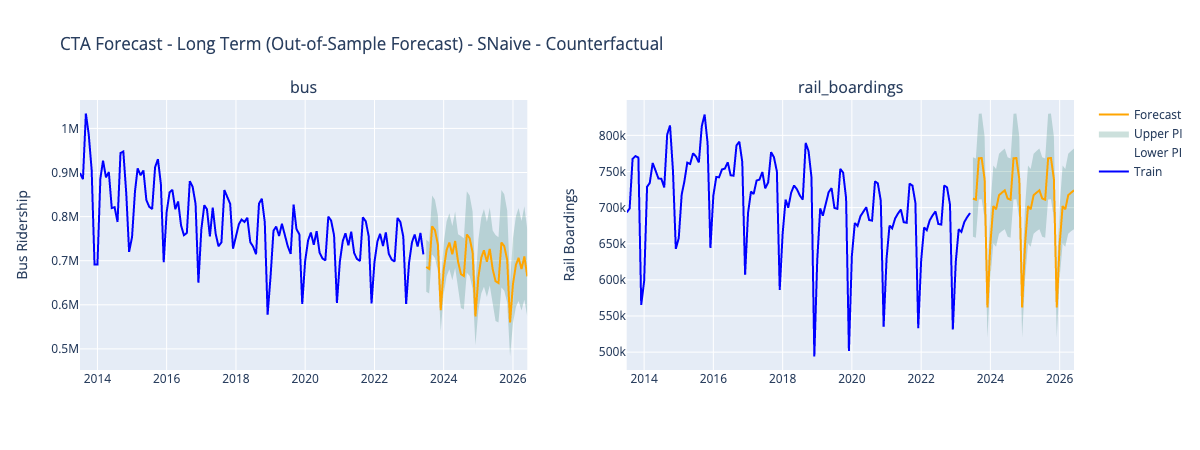

In [36]:
snaive_trainer_counterfactual.plot_forecast(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=365.25 * 10),
    pi=forecast_results_snaive_counterfactual["pi"],
    y_train=forecast_results_snaive_counterfactual["y_train"],
    y_pred=forecast_results_snaive_counterfactual["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Long Term (Out-of-Sample Forecast) - SNaive - Counterfactual",
)

### Original Data

In [ ]:
snaive_trainer_original = SNaiveTrainer(
    horizon="long",
    config_path="../src/config",
    config_name="original_snaive_trainer",
    logger_name="original_snaive_trainer",
    s3_helper=s3_helper,
    data_type="original",
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    snaive_trainer_original.cross_validate(verbose=2, n_jobs=-1, refit=True)

CV results:

In [38]:
snaive_trainer_original.grid_search.cv_results_.sort_values(
    "mean_test_MeanSquaredError"
)

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
115,63209.759751,0.172875,0.098432,"{'bus__deseasonalize__passthrough': False, 'bu...",1.5
43,63209.759751,0.188368,0.133278,"{'bus__deseasonalize__passthrough': True, 'bus...",1.5
37,63209.759751,0.188551,0.125144,"{'bus__deseasonalize__passthrough': True, 'bus...",3.5
109,63209.759751,0.162750,0.103743,"{'bus__deseasonalize__passthrough': False, 'bu...",3.5
36,65504.636303,0.180792,0.194650,"{'bus__deseasonalize__passthrough': True, 'bus...",6.5
...,...,...,...,...,...
14,120641.210847,0.130088,0.044659,"{'bus__deseasonalize__passthrough': True, 'bus...",140.0
65,120726.418449,0.211694,0.062794,"{'bus__deseasonalize__passthrough': True, 'bus...",141.0
29,120726.418449,0.185992,0.062070,"{'bus__deseasonalize__passthrough': True, 'bus...",142.0
26,120726.418449,0.168098,0.054099,"{'bus__deseasonalize__passthrough': True, 'bus...",143.0


Best parameters:

In [39]:
pd.DataFrame(
    snaive_trainer_original.grid_search.best_params_, index=["Best Parameters"]
)

,bus__deseasonalize__passthrough,bus__detrend__passthrough,bus__snaive__strategy,rail_boardings__deseasonalize__passthrough,rail_boardings__detrend__passthrough,rail_boardings__snaive__strategy
Best Parameters,True,False,last,False,True,mean


#### Diagnostics

In [40]:
diagnostics_cv_snaive_original = snaive_trainer_original.diagnostics(full_model=False)
diagnostics_cv_snaive_original["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,5.813384e-15,True,True,True
1,Ljung-Box,No Autocorrelation,6.830820e-12,True,True,True


In [41]:
diagnostics_cv_snaive_original["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


#### Refit and Forecast

In [42]:
forecast_results_snaive_original = snaive_trainer_original.refit_and_forecast(
    level=config["long"]["pred_interval"]
)

2023-11-06 19:27:57,945 INFO original_snaive_trainer: Refitting model on entire data...
2023-11-06 19:27:58,020 INFO original_snaive_trainer: Making out-of-sample forecasts...


In [43]:
diagnostics_refit_snaive_original = snaive_trainer_original.diagnostics(full_model=True)
diagnostics_refit_snaive_original["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.380513e-15,True,True,True
1,Ljung-Box,No Autocorrelation,6.243284e-23,True,True,True


In [44]:
diagnostics_refit_snaive_original["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.0,False,False,False
1,Ljung-Box,No Autocorrelation,NaN,False,False,False


Plot the out-of-sample forecasts:

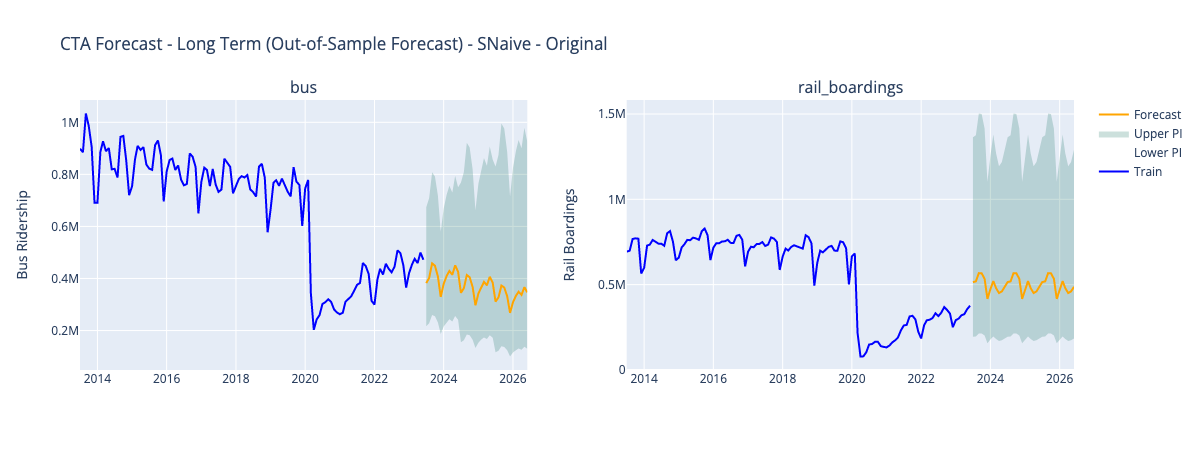

In [45]:
snaive_trainer_original.plot_forecast(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=365.25 * 10),
    pi=forecast_results_snaive_original["pi"],
    y_train=forecast_results_snaive_original["y_train"],
    y_pred=forecast_results_snaive_original["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Long Term (Out-of-Sample Forecast) - SNaive - Original",
)

### Seasonal Naive Comparison Plot (Counterfactual vs Original)

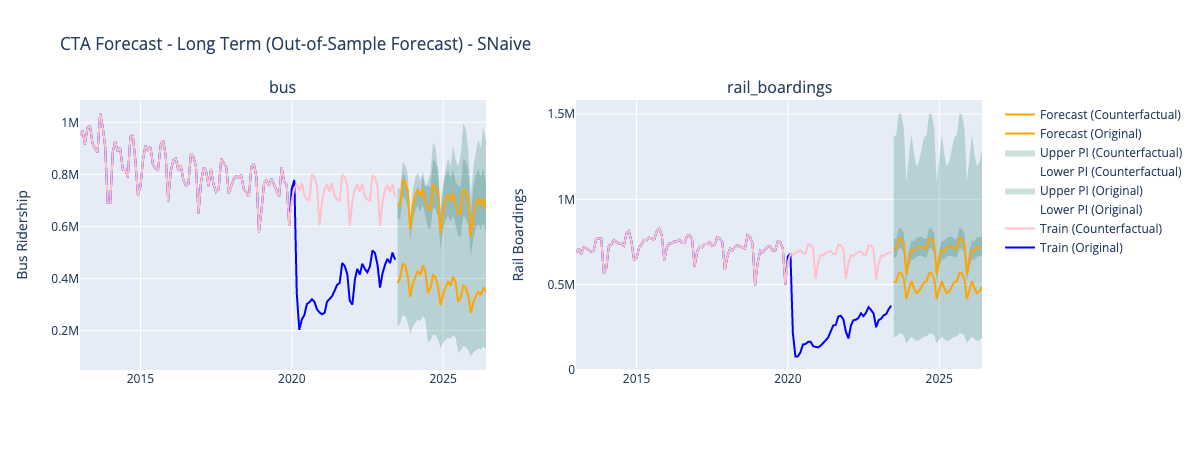

In [46]:
SNaiveTrainer.plot_forecast_comparison(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=365.25 * 10),
    pi_original=forecast_results_snaive_original["pi"],
    y_train_original=forecast_results_snaive_original["y_train"],
    y_pred_original=forecast_results_snaive_original["y_pred"],
    pi_counterfactual=forecast_results_snaive_counterfactual["pi"],
    y_train_counterfactual=forecast_results_snaive_counterfactual["y_train"],
    y_pred_counterfactual=forecast_results_snaive_counterfactual["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Long Term (Out-of-Sample Forecast) - SNaive",
)

### Model Persistence

In [47]:
for trainer, data_type in zip(
    [snaive_trainer_counterfactual, snaive_trainer_original],
    ["counterfactual", "original"],
):
    trainer.upload_trainer(
        obj_key=os.path.join(
            config["long"]["model_key"], f"{data_type}_snaive_trainer.joblib"
        )
    )

2023-11-06 19:28:26,859 INFO counterfactual_snaive_trainer: Uploaded trainer object to models/long/counterfactual_snaive_trainer.joblib
2023-11-06 19:28:27,146 INFO original_snaive_trainer: Uploaded trainer object to models/long/original_snaive_trainer.joblib


## STL

The STL algorithm can be summarized as follows:

- **Fit Phase:**
  - **Decomposition:**
    - Utilize `statsmodels` STL to decompose the input series $y$ into:
      - Trend component
      - Seasonal component
      - Residuals
  - **Model Fitting:**
    - Fit separate models to each component:
      - `forecaster_trend` (`AutoETS` with tuned `damped` hyperparameter) to the trend component
      - `forecaster_seasonal` (`AutoETS` with tuned `damped` hyperparameter) to the seasonal component
      - `forecaster_resid` (`AutoETS` with tuned `damped` hyperparameter) to the residuals
    - Store these model clones as attributes: `forecaster_trend_`, `forecaster_seasonal_`, `forecaster_resid_`

- **Predict Phase:**
  - **Component Forecasting:**
    - Generate forecasts for each component using corresponding fitted forecasters:
      - `y_pred_trend` from `forecaster_trend_`
      - `y_pred_seasonal` from `forecaster_seasonal_`
      - `y_pred_residual` from `forecaster_resid_`
  - **Recomposition:**
    - Recompose the final forecast `y_pred` by summing the individual forecasts:
      
      $$\text{y pred = y pred (trend) + y pred (seasonal) + y pred (residual)}$$

### Cross-Validation

### Counterfactual Data

In [68]:
stl_trainer_counterfactual = STLTrainer(
    horizon="long",
    config_path="../src/config",
    config_name="counterfactual_stl_trainer",
    logger_name="counterfactual_stl_trainer",
    s3_helper=s3_helper,
    data_type="counterfactual",
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stl_trainer_counterfactual.cross_validate(verbose=2, n_jobs=-1, refit=True)

2023-11-06 23:29:12,182 INFO counterfactual_stl_trainer: Ingesting data...
2023-11-06 23:29:12,849 INFO counterfactual_stl_trainer: Creating cross-validation splitter...
2023-11-06 23:29:12,850 INFO counterfactual_stl_trainer: Creating model...
Fitting 14 folds for each of 1024 candidates, totalling 14336 fits
2023-11-06 23:57:32,624 INFO counterfactual_stl_trainer: Best params: {'bus__deseasonalize__passthrough': False, 'bus__detrend__passthrough': True, 'bus__slt__forecaster_resid__damped': False, 'bus__slt__forecaster_seasonal__damped': False, 'bus__slt__forecaster_trend__damped': False, 'rail_boardings__deseasonalize__passthrough': True, 'rail_boardings__detrend__passthrough': True, 'rail_boardings__slt__forecaster_resid__damped': False, 'rail_boardings__slt__forecaster_seasonal__damped': True, 'rail_boardings__slt__forecaster_trend__damped': True}
2023-11-06 23:57:32,625 INFO counterfactual_stl_trainer: Best score: 39472.68367038631


CV results:

In [71]:
stl_trainer_counterfactual.grid_search.cv_results_.sort_values(
    "mean_test_MeanSquaredError"
)

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
740,39472.683670,0.905950,0.071750,"{'bus__deseasonalize__passthrough': False, 'bu...",1.0
612,39484.617522,0.924008,0.073321,"{'bus__deseasonalize__passthrough': False, 'bu...",2.0
676,39627.116788,0.901809,0.076055,"{'bus__deseasonalize__passthrough': False, 'bu...",3.0
548,39637.989139,0.851633,0.072418,"{'bus__deseasonalize__passthrough': False, 'bu...",4.0
756,39684.884578,0.928131,0.075032,"{'bus__deseasonalize__passthrough': False, 'bu...",5.0
...,...,...,...,...,...
89,50843.537243,0.644545,0.074444,"{'bus__deseasonalize__passthrough': True, 'bus...",1020.0
219,50978.566105,0.702032,0.076444,"{'bus__deseasonalize__passthrough': True, 'bus...",1021.0
91,50979.759673,0.654753,0.071928,"{'bus__deseasonalize__passthrough': True, 'bus...",1022.0
203,51027.996490,0.731549,0.077985,"{'bus__deseasonalize__passthrough': True, 'bus...",1023.0


Best parameters:

In [74]:
pd.DataFrame(
    stl_trainer_counterfactual.grid_search.best_params_, index=["Best Parameters"]
).T

,Best Parameters
bus__deseasonalize__passthrough,False
bus__detrend__passthrough,True
bus__slt__forecaster_resid__damped,False
bus__slt__forecaster_seasonal__damped,False
bus__slt__forecaster_trend__damped,False
rail_boardings__deseasonalize__passthrough,True
rail_boardings__detrend__passthrough,True
rail_boardings__slt__forecaster_resid__damped,False
rail_boardings__slt__forecaster_seasonal__damped,True
rail_boardings__slt__forecaster_trend__damped,True


#### Diagnostics

In [72]:
diagnostics_cv_stl_counterfactual = stl_trainer_counterfactual.diagnostics(
    full_model=False
)
diagnostics_cv_stl_counterfactual["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,0.000005,True,True,True
1,Ljung-Box,No Autocorrelation,0.016957,False,True,True


In [73]:
diagnostics_cv_stl_counterfactual["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,9.146149e-07,True,True,True
1,Ljung-Box,No Autocorrelation,5.191138e-01,False,False,False


#### Refit and Forecast

In [100]:
forecast_results_stl_counterfactual = stl_trainer_counterfactual.refit_and_forecast()

2023-11-07 00:31:06,662 INFO counterfactual_stl_trainer: Refitting model on entire data...
2023-11-07 00:31:07,541 INFO counterfactual_stl_trainer: Making out-of-sample forecasts...


In [101]:
diagnostics_refit_stl_counterfactual = stl_trainer_counterfactual.diagnostics(
    full_model=True
)
diagnostics_refit_stl_counterfactual["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.538506e-10,True,True,True
1,Ljung-Box,No Autocorrelation,1.714522e-03,True,True,True


In [102]:
diagnostics_refit_stl_counterfactual["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,2.225812e-13,True,True,True
1,Ljung-Box,No Autocorrelation,1.106482e-02,False,True,True


Plot out-of-sample forecasts:

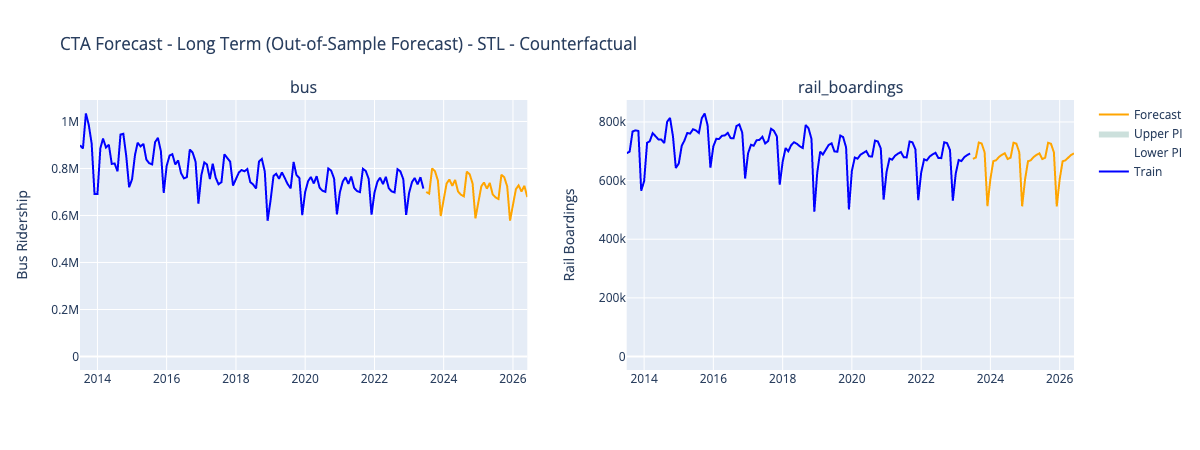

In [103]:
stl_trainer_counterfactual.plot_forecast(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=365.25 * 10),
    y_train=forecast_results_stl_counterfactual["y_train"],
    y_pred=forecast_results_stl_counterfactual["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Long Term (Out-of-Sample Forecast) - STL - Counterfactual",
)

### Original Data

In [104]:
stl_trainer_original = STLTrainer(
    horizon="long",
    config_path="../src/config",
    config_name="original_stl_trainer",
    logger_name="original_stl_trainer",
    s3_helper=s3_helper,
    data_type="original",
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stl_trainer_original.cross_validate(verbose=2, n_jobs=-1, refit=True)

2023-11-07 00:33:45,661 INFO original_stl_trainer: Ingesting data...
2023-11-07 00:33:46,092 INFO original_stl_trainer: Creating cross-validation splitter...
2023-11-07 00:33:46,094 INFO original_stl_trainer: Creating model...
Fitting 14 folds for each of 1024 candidates, totalling 14336 fits
2023-11-07 01:03:02,083 INFO original_stl_trainer: Best params: {'bus__deseasonalize__passthrough': False, 'bus__detrend__passthrough': False, 'bus__slt__forecaster_resid__damped': True, 'bus__slt__forecaster_seasonal__damped': False, 'bus__slt__forecaster_trend__damped': False, 'rail_boardings__deseasonalize__passthrough': False, 'rail_boardings__detrend__passthrough': True, 'rail_boardings__slt__forecaster_resid__damped': False, 'rail_boardings__slt__forecaster_seasonal__damped': True, 'rail_boardings__slt__forecaster_trend__damped': True}
2023-11-07 01:03:02,089 INFO original_stl_trainer: Best score: 71279.12493607242


CV results:

In [105]:
stl_trainer_original.grid_search.cv_results_.sort_values("mean_test_MeanSquaredError")

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
884,71279.124936,0.721072,0.079694,"{'bus__deseasonalize__passthrough': False, 'bu...",1.0
1012,71284.398834,0.732262,0.075427,"{'bus__deseasonalize__passthrough': False, 'bu...",2.0
628,71330.806076,0.982277,0.088146,"{'bus__deseasonalize__passthrough': False, 'bu...",3.0
756,71332.011862,0.936858,0.076621,"{'bus__deseasonalize__passthrough': False, 'bu...",4.0
852,71366.459364,0.686510,0.077064,"{'bus__deseasonalize__passthrough': False, 'bu...",5.0
...,...,...,...,...,...
73,83038.930975,0.683483,0.081678,"{'bus__deseasonalize__passthrough': True, 'bus...",1020.0
219,83089.196121,0.700631,0.076663,"{'bus__deseasonalize__passthrough': True, 'bus...",1021.0
91,83089.910168,0.690551,0.075939,"{'bus__deseasonalize__passthrough': True, 'bus...",1022.0
203,83319.649989,0.694466,0.072042,"{'bus__deseasonalize__passthrough': True, 'bus...",1023.0


Best parameters:

In [106]:
pd.DataFrame(stl_trainer_original.grid_search.best_params_, index=["Best Parameters"]).T

,Best Parameters
bus__deseasonalize__passthrough,False
bus__detrend__passthrough,False
bus__slt__forecaster_resid__damped,True
bus__slt__forecaster_seasonal__damped,False
bus__slt__forecaster_trend__damped,False
rail_boardings__deseasonalize__passthrough,False
rail_boardings__detrend__passthrough,True
rail_boardings__slt__forecaster_resid__damped,False
rail_boardings__slt__forecaster_seasonal__damped,True
rail_boardings__slt__forecaster_trend__damped,True


#### Diagnostics

In [107]:
diagnostics_cv_stl_original = stl_trainer_original.diagnostics(full_model=False)
diagnostics_cv_stl_original["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,8.371811e-12,True,True,True
1,Ljung-Box,No Autocorrelation,3.222161e-01,False,False,False


In [108]:
diagnostics_cv_stl_original["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,3.623994e-15,True,True,True
1,Ljung-Box,No Autocorrelation,5.527400e-02,False,False,True


The independent error assumption is satisfied at the $5\%$ Type-I error rate. However, the normality assumption is not satisfied. The STL forecasting algorithm does not support prediction intervals.

#### Refit and Forecast

In [109]:
forecast_results_stl_original = stl_trainer_original.refit_and_forecast()

2023-11-07 01:05:11,370 INFO original_stl_trainer: Refitting model on entire data...
2023-11-07 01:05:12,078 INFO original_stl_trainer: Making out-of-sample forecasts...


In [110]:
diagnostics_refit_stl_original = stl_trainer_original.diagnostics(full_model=True)
diagnostics_refit_stl_original["bus"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,8.052734e-16,True,True,True
1,Ljung-Box,No Autocorrelation,2.721213e-02,False,True,True


In [111]:
diagnostics_refit_stl_original["rail_boardings"]

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normal,1.027756e-18,True,True,True
1,Ljung-Box,No Autocorrelation,1.704189e-02,False,True,True


Plot out-of-sample forecast:

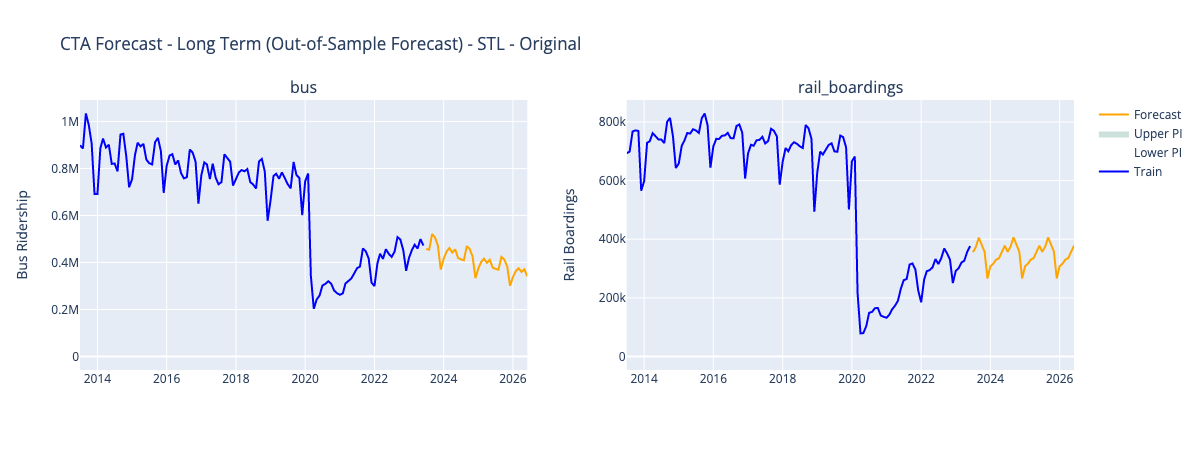

In [112]:
stl_trainer_original.plot_forecast(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=365.25 * 10),
    y_train=forecast_results_stl_original["y_train"],
    y_pred=forecast_results_stl_original["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Long Term (Out-of-Sample Forecast) - STL - Original",
)

### STL Forecaster Comparison Plot (Counterfactual vs Original)

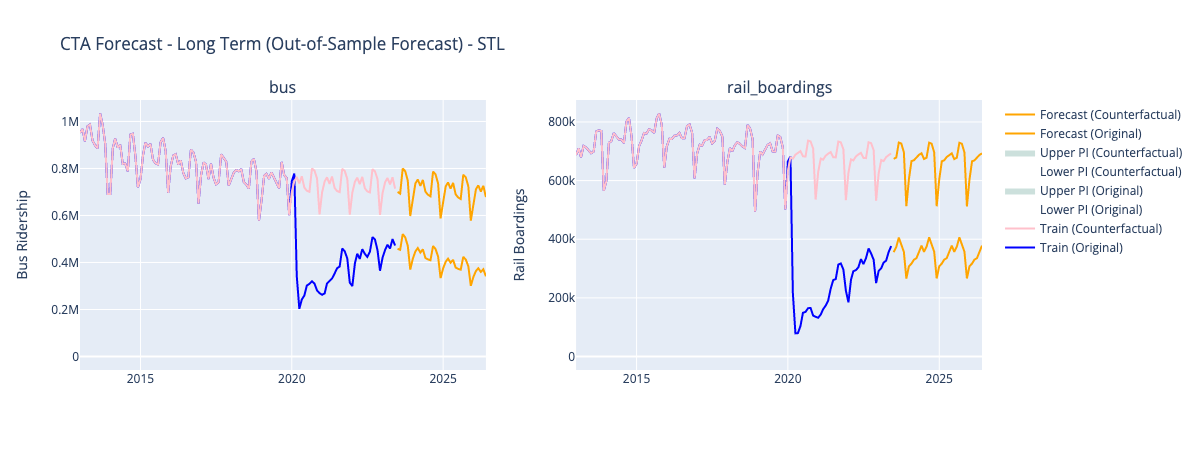

In [115]:
STLTrainer.plot_forecast_comparison(
    start_date=y_test["service_date"].max() - pd.Timedelta(days=365.25 * 10),
    y_train_original=forecast_results_stl_original["y_train"],
    y_pred_original=forecast_results_stl_original["y_pred"],
    y_train_counterfactual=forecast_results_stl_counterfactual["y_train"],
    y_pred_counterfactual=forecast_results_stl_counterfactual["y_pred"],
    static=True,  # Set to False for interactive plot
    title="CTA Forecast - Long Term (Out-of-Sample Forecast) - STL",
)

### Model Persistence

In [116]:
for trainer, data_type in zip(
    [stl_trainer_counterfactual, stl_trainer_original], ["counterfactual", "original"]
):
    trainer.upload_trainer(
        obj_key=os.path.join(
            config["long"]["model_key"], f"{data_type}_stl_trainer.joblib"
        )
    )

2023-11-07 01:06:20,026 INFO counterfactual_stl_trainer: Uploaded trainer object to models/long/counterfactual_stl_trainer.joblib
2023-11-07 01:06:22,065 INFO original_stl_trainer: Uploaded trainer object to models/long/original_stl_trainer.joblib
